<a href="https://colab.research.google.com/github/botkin92/Data_analysis_algorithms/blob/lesson_6/Lesson_6_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Урок 6. Градиентный бустинг. AdaBoost.

## Реализация алгоритма градиентного бустинга (из методички)

Реализуем средствами Python алгоритм градиентного бустинга для деревьев решений.

Реализация деревьев решений была дважды продемонстрирована в предыдущих уроках, в этом не будем ее повторять и возьмем готовую реализацию дерева решений для регрессии из библиотеки `sklearn`.

In [ ]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np

Используем один из "игрушечных" датасетов из той же библиотеки.

In [ ]:
from sklearn.datasets import load_diabetes

In [ ]:
X, y = load_diabetes(return_X_y=True)

Разделим выборку на обучающую и тестовую в соотношении 75/25.

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

Напишем функцию, реализующую предсказание в градиентном бустинге.

In [ ]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функцию.

In [ ]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

Используем $L_{2}$ loss $L(y, z) = (y-z)^{2},$ ее производная по $z$ примет вид $L'(y, z) = 2(z-y)$. Реализуем ее также в виде функции (коэффициент 2 можно отбросить).

In [ ]:
def bias(y, z):
    return (y - z)

Реализуем функцию обучения градиентного бустинга.

In [ ]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=5)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

Теперь обучим модель.

In [ ]:
%%time
# Число деревьев в ансамбле
n_trees = 15

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 0.19

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

CPU times: user 8.3 s, sys: 281 ms, total: 8.58 s
Wall time: 9.33 s


In [ ]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    train_prediction = gb_predict(X_train, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

In [ ]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 15 деревьев глубиной 3     с шагом 0.19 на тренировочной выборке: 1750.3495086887785
Ошибка алгоритма из 15 деревьев глубиной 3     с шагом 0.19 на тестовой выборке: 3684.9190068524044


Построим графики зависимости ошибки на обучающей и тестовой выборках от числа итераций.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [ ]:
def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

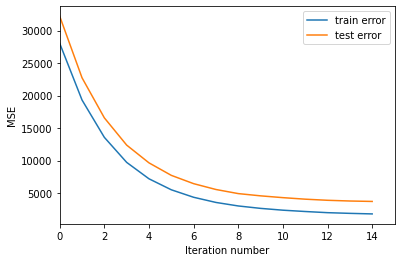

In [ ]:
get_error_plot(n_trees, train_errors, test_errors)

## Домашнее задание 

1. Для реализованной модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

Создадим/переберем несколько моделей с различным количеством деревьев и глубиной. Шаг обучения оставим постоянным.

In [ ]:
max_depth = 3  # максимальная глубина деревьев
eta = 0.05  # шаг

In [ ]:
%%time
n_trees_list = [5, 15, 20, 30, 40, 50, 100]  # варьируем количество деревьев в ансамбле
train_errors_list = []
test_errors_list = []

for n in n_trees_list:
    coefs = [1] * n
    trees, train_errors, test_errors = gb_fit(n, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    train_errors_list.append(train_errors[-1])
    test_errors_list.append(test_errors[-1])

CPU times: user 8min 24s, sys: 28.6 s, total: 8min 53s
Wall time: 8min 23s


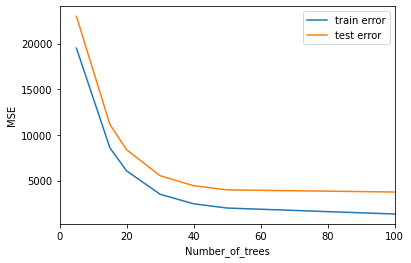

In [ ]:
plt.xlabel('Number_of_trees')
plt.ylabel('MSE')
plt.xlim(0, max(n_trees_list))
plt.plot(n_trees_list, train_errors_list, label='train error')
plt.plot(n_trees_list, test_errors_list, label='test error')
plt.legend(loc='upper right')
plt.show()

При увеличении количества деревьев в ансамбле ошибка уменьшается до некоторого значения (при количестве деревьев - 40). Далее значение ошибки снижается не существенно и при этом отмечается эффект переобучения.

In [ ]:
n_trees = 20  # число деревьев в ансамбле
coefs = [1] * n_trees  # для простоты примем коэффициенты равными 1
eta = 0.05  # шаг

In [ ]:
%%time
max_depth_list = [3, 5, 7, 10, 20, 30]  # варьируем максимальную глубину деревьев
train_errors_list2 = []
test_errors_list2 = []

for n in max_depth_list:
    trees, train_errors, test_errors = gb_fit(n_trees, n, X_train, X_test, y_train, y_test, coefs, eta)
    train_errors_list2.append(train_errors[-1])
    test_errors_list2.append(test_errors[-1])

CPU times: user 1min 12s, sys: 3.26 s, total: 1min 15s
Wall time: 1min 12s


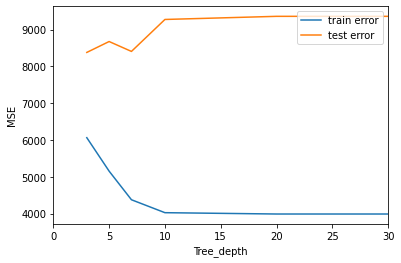

In [ ]:
plt.xlabel('Tree_depth')
plt.ylabel('MSE')
plt.xlim(0, max(max_depth_list))
plt.plot(max_depth_list, train_errors_list2, label='train error')
plt.plot(max_depth_list, test_errors_list2, label='test error')
plt.legend(loc='upper right')
plt.show()

При увеличении глубины дерева ошибка снижается, хотя на тестовой выборке закономерность не наблюдается. Также имеется переобучение при большой глубине (более 5).

2. Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

In [ ]:
import random

In [ ]:
def gb_sth_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    sth_train_errors = []
    test_errors = []
    
    # Размер подвыборок примем за половину от тренировочной
    n_samples = int(X_train.shape[0]*0.5)
    all_samples = X_train.shape[0]

    # Подвыборка для стохастического градиентного бустинга
    sth_data = np.zeros((n_samples, X_train.shape[1]))
    sth_target = np.zeros(n_samples)

    # Сформируем подвыборку
    for j in range(n_samples):
        sample_index = random.randint(0, all_samples-1)
        sth_data[j,:] = X_train[sample_index,:]
        sth_target[j] = y_train[sample_index]

    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=5)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(sth_data, sth_target)
            
            sth_train_errors.append(mean_squared_error(sth_target, gb_predict(sth_data, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(sth_data, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(sth_data, bias(sth_target, target))
            
            sth_train_errors.append(mean_squared_error(sth_target, gb_predict(sth_data, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, sth_train_errors, test_errors

In [ ]:
%%time
# Число деревьев в ансамбле
n_trees = 15

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 0.1

sth_trees, sth_train_errors, sth_test_errors = gb_sth_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

CPU times: user 4.05 s, sys: 239 ms, total: 4.29 s
Wall time: 3.96 s


In [ ]:
evaluate_alg(X_train, X_test, y_train, y_test, sth_trees, coefs, eta)

Ошибка алгоритма из 15 деревьев глубиной 3     с шагом 0.1 на тренировочной выборке: 3524.075562606368
Ошибка алгоритма из 15 деревьев глубиной 3     с шагом 0.1 на тестовой выборке: 5156.308448447121


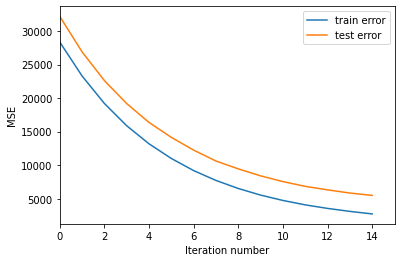

In [ ]:
get_error_plot(n_trees, sth_train_errors, sth_test_errors)

Для сравнения обучим деревья на тех же параметрах с градиентным бустингом:

In [ ]:
%%time
trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

CPU times: user 7.07 s, sys: 367 ms, total: 7.44 s
Wall time: 6.96 s


In [ ]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 15 деревьев глубиной 3     с шагом 0.1 на тренировочной выборке: 3248.923726568342
Ошибка алгоритма из 15 деревьев глубиной 3     с шагом 0.1 на тестовой выборке: 5131.626178153384


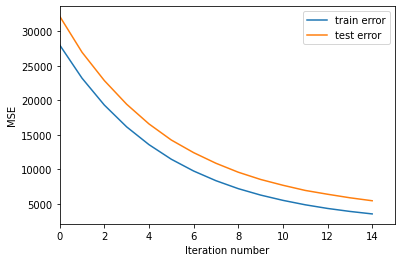

In [ ]:
get_error_plot(n_trees, train_errors, test_errors)